In [27]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [28]:
spark = SparkSession.builder.appName("LogisticRegressionBollywood").getOrCreate()
data = pd.read_csv("diabetes_prediction_dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [29]:
data = spark.read.csv("diabetes_prediction_dataset.csv", header=True, inferSchema=True)

target_col = "diabetes"
data = data.drop("gender")
data = data.drop("smoking_history")
feature_cols = [col for col in data.columns if col != target_col]

vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

data = vector_assembler.transform(data)

In [30]:
train_data, test_data = data.randomSplit([0.9, 0.1], seed=123)

In [31]:
svm = LinearSVC(labelCol=target_col, featuresCol="features", maxIter=10, regParam=0.1)
model = svm.fit(train_data)

predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="accuracy"
)

In [32]:
s=[]
for i in range(1,10):
    
    train_data1, test_data1 = data.randomSplit([i/10, 1-(i/10)], seed=123)

    ls1 = LinearSVC(labelCol=target_col, featuresCol="features")
    model1 = ls1.fit(train_data1)
    predictions1 = model.transform(test_data1)

    evaluator1 = MulticlassClassificationEvaluator(
        labelCol=target_col, predictionCol="prediction", metricName="accuracy"
    )
    accuracy1 = evaluator1.evaluate(predictions1)
    s.append(accuracy1)


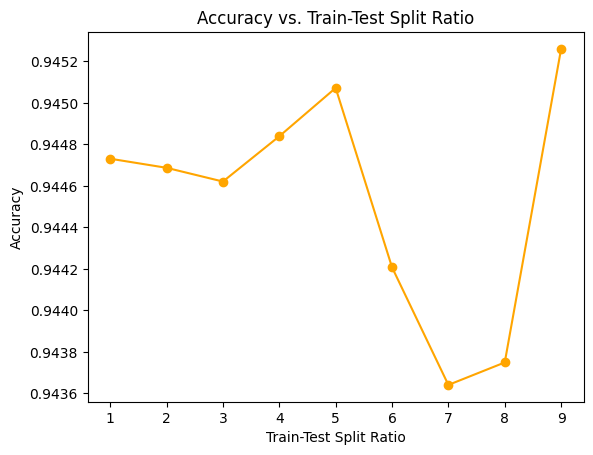

In [33]:
plt.plot(range(1, 10), s, marker='o',color = 'orange')
plt.title('Accuracy vs. Train-Test Split Ratio')
plt.xlabel('Train-Test Split Ratio')
plt.ylabel('Accuracy')
plt.show()

In [34]:
accuracy = evaluator.evaluate(predictions)
tp = predictions.filter("diabetes = 1 AND prediction = 1").count()
fp = predictions.filter("diabetes = 0 AND prediction = 1").count()
tn = predictions.filter("diabetes = 0 AND prediction = 0").count()
fn = predictions.filter("diabetes = 1 AND prediction = 0").count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.9452602137648587
Precision: 0.9967637540453075
Recall: 0.36023391812865496
F1 Score: 0.5292096219931272


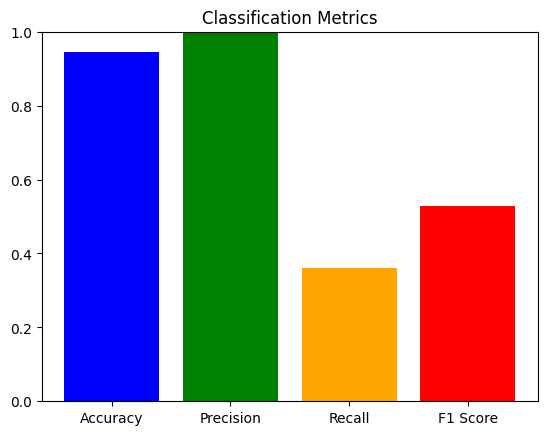

In [40]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1_score]

plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)
plt.title('Classification Metrics')
plt.show()

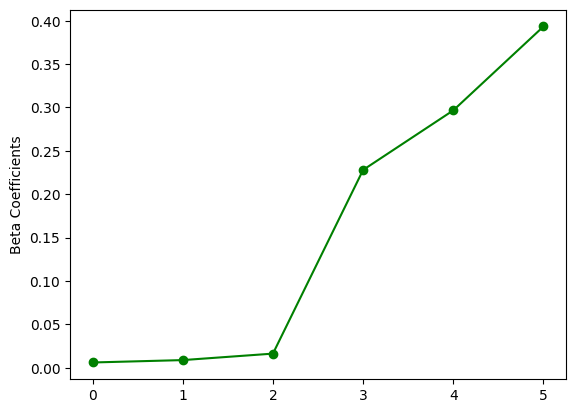

In [35]:
beta = np.sort(model.coefficients)
plt.plot(beta,marker ='o',color = 'green')
plt.ylabel('Beta Coefficients')
plt.show()

In [36]:
prediction_and_label = predictions.select("prediction", target_col).rdd.map(lambda row: (float(row.prediction), float(row[target_col])))

metrics = MulticlassMetrics(prediction_and_label)

confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)

C:\Users\blruc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[9.155e+03 1.000e+00]
 [5.470e+02 3.080e+02]]


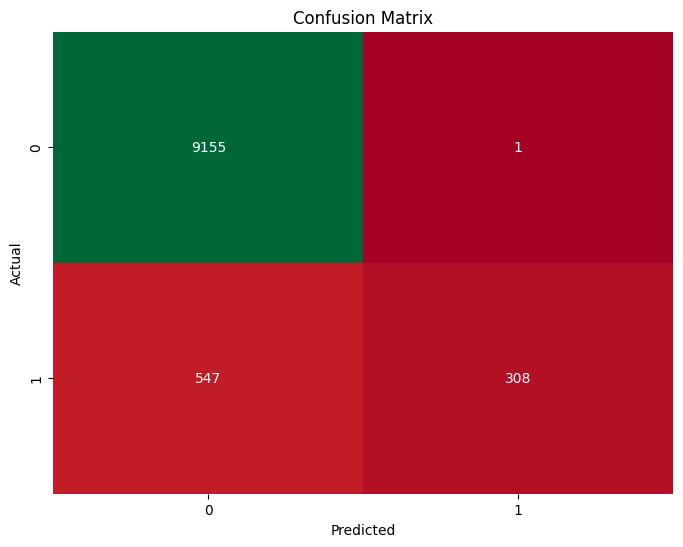

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap=sns.color_palette("RdYlGn", as_cmap=True), cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [38]:
predictions = model.transform(test_data)
predictions.show(10)


+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+--------------------+----------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|            features|       rawPrediction|prediction|
+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+--------------------+----------+
|0.08|           0|            0|11.88|        5.7|                 80|       0|[0.08,0.0,0.0,11....|[2.55452799842313...|       0.0|
|0.08|           0|            0|12.29|        5.8|                140|       0|[0.08,0.0,0.0,12....|[1.97959632380020...|       0.0|
|0.08|           0|            0|12.89|        6.5|                145|       0|[0.08,0.0,0.0,12....|[1.65039226713350...|       0.0|
|0.08|           0|            0|14.73|        3.5|                200|       0|[0.08,0.0,0.0,14....|[2.31568448422861...|       0.0|
|0.08|           0|            0|27.32|        5.0|           

In [39]:
spark.stop()